# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
# #install ipywidgets
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 34.3 MB/s eta 0:00:01
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from ipywidgets import FloatProgress
# Define transforms
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      
                                      transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root = 'data', transform=train_transforms, download = True, )
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)


# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root = 'data',train = False, transform=test_transforms, download = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I transformed the data by changing it to the tensor datatype and normalizing it. Changing the data to the tensor format allows it to be able to run on GPUs and other specialized hardware to accelarating the training and testing process. 

Also, normalization allows data that has different ranges to fall within the similar range or common scale without distorting the core nature of the data with respect to each other. This helps with faster convergence of gradient descent.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
#show some of the image tensor in a batch
dataiter = iter(trainloader)
next(dataiter)

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


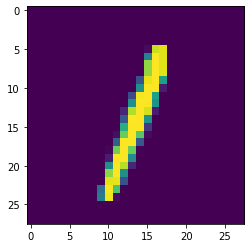

1


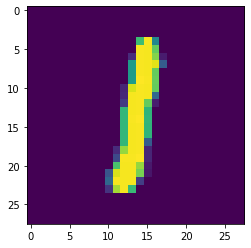

8


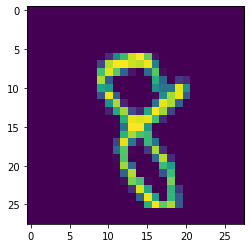

4


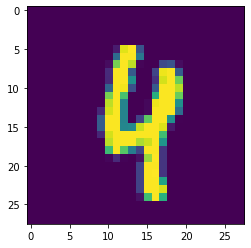

2


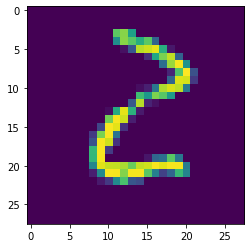

In [5]:
show5(trainloader)

In [21]:
# Explore data
#Check the total size of the training and testing data 
print(train_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 120)
        self.dropout = nn.Dropout(p = 0.4)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
epochs = 13
net.to(device) #move the model to the GPU if it is available
train_loss = [] #list of training loss per epoch
for e in range(epochs):
    running_loss = 0 #track the running loss while training


    for i, data in enumerate(trainloader):
        
        images, labels = data

        images = images.to(device) 
        labels = labels.to(device) # move the images and labels to the GPU also

        #send the gradients to zero  
        optimizer.zero_grad()
        
        #perform the forward pass
        output = net(images)
        loss = criterion(output, labels)

        #perform backward pass and optimize

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    

    #now for the validation
    print(f"Epoch {e+1}/{epochs}.. "
      f"Train loss: {running_loss/len(trainloader):.3f}.. ")
    train_loss.append(running_loss/len(trainloader))
#net.train() #put the model back in training mode for the next epoch





Epoch 1/13.. Train loss: 0.499.. 
Epoch 2/13.. Train loss: 0.313.. 
Epoch 3/13.. Train loss: 0.276.. 
Epoch 4/13.. Train loss: 0.255.. 
Epoch 5/13.. Train loss: 0.238.. 
Epoch 6/13.. Train loss: 0.226.. 
Epoch 7/13.. Train loss: 0.215.. 
Epoch 8/13.. Train loss: 0.208.. 
Epoch 9/13.. Train loss: 0.202.. 
Epoch 10/13.. Train loss: 0.195.. 
Epoch 11/13.. Train loss: 0.193.. 
Epoch 12/13.. Train loss: 0.187.. 
Epoch 13/13.. Train loss: 0.186.. 


Plot the training loss (and validation loss/accuracy, if recorded).

[0.4987793857336044, 0.31264963982005917, 0.27611603643894195, 0.2550138545314471, 0.23768186855514845, 0.2257658562573294, 0.21466474865178267, 0.2079847124154369, 0.2024671995376547, 0.19527506968627373, 0.19321834267651042, 0.18720458959986766, 0.18592453001886605]


Text(0.5, 1.0, 'Training loss')

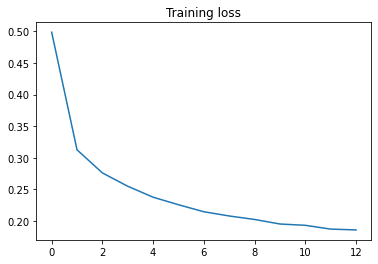

In [11]:
## YOUR CODE HERE ##
print(train_loss)
plt.plot(train_loss, label='Training loss');
plt.title('Training loss')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
#testing 
accuracy = 0
correct_preds =0 #number of correct predictions

with torch.no_grad(): #turn off gradients to stop keeping track of gradients 
    net.eval() #put the model in evaluation mode

    for images, labels in testloader:
        
        #move to the GPU
        images, labels = images.to(device), labels.to(device)
        
        #perform prediction 
        outputs = net(images)
        
        #compare the predcitions with the labels
        
        _, predictions = torch.max(outputs.data, 1)
        correct_preds += (predictions == labels).sum().item()
        
    accuracy = (correct_preds/len(test_data))*100

    print(f"Test accuracy: {accuracy:.3f}%")


Test accuracy: 96.440%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
## YOUR CODE HERE ##

##MODEL DEFINITION##

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 400)
        self.dropout = nn.Dropout(p = 0.4)
        self.fc2 = nn.Linear(400, 312)
        self.fc3 = nn.Linear(312, 285)
        self.fc4 = nn.Linear(285, 140)
        self.dropout = nn.Dropout(p = 0.4)
        self.fc5 = nn.Linear(140, 10)
        

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        
        x = self.fc5(x)
        return x

# Instantiate the model
net = Net()
net.to(device)


## OPTIMIZER AND LOSS FUNCTION##

# Choose an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.8)

# Choose a loss function
criterion = nn.CrossEntropyLoss()



##MODEL TRAINING##

epochs = 20
net.to(device) #move the model to the GPU if it is available
train_loss = [] #list of training loss per epoch
for e in range(epochs):
    running_loss = 0 #track the running loss while training


    for i, data in enumerate(trainloader):
        
        images, labels = data

        images = images.to(device) 
        labels = labels.to(device) # move the images and labels to the GPU also

        #send the gradients to zero  
        optimizer.zero_grad()
        
        #perform the forward pass
        output = net(images)
        loss = criterion(output, labels)

        #perform backward pass and optimize

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    

    #now for the validation
    print(f"Epoch {e+1}/{epochs}.. "
      f"Train loss: {running_loss/len(trainloader):.3f}.. ")
    train_loss.append(running_loss/len(trainloader))
#net.train() #put the model back in training mode for the next epoch




Epoch 1/20.. Train loss: 2.213.. 
Epoch 2/20.. Train loss: 0.988.. 
Epoch 3/20.. Train loss: 0.502.. 
Epoch 4/20.. Train loss: 0.387.. 
Epoch 5/20.. Train loss: 0.316.. 
Epoch 6/20.. Train loss: 0.270.. 
Epoch 7/20.. Train loss: 0.239.. 
Epoch 8/20.. Train loss: 0.212.. 
Epoch 9/20.. Train loss: 0.191.. 
Epoch 10/20.. Train loss: 0.173.. 
Epoch 11/20.. Train loss: 0.163.. 
Epoch 12/20.. Train loss: 0.151.. 
Epoch 13/20.. Train loss: 0.143.. 
Epoch 14/20.. Train loss: 0.134.. 
Epoch 15/20.. Train loss: 0.125.. 
Epoch 16/20.. Train loss: 0.119.. 
Epoch 17/20.. Train loss: 0.116.. 
Epoch 18/20.. Train loss: 0.109.. 
Epoch 19/20.. Train loss: 0.105.. 
Epoch 20/20.. Train loss: 0.101.. 


[2.2130392358779907, 0.9879798249562581, 0.5020356146415075, 0.38661165591478347, 0.3161396962702274, 0.269942748204867, 0.23877148688534897, 0.21171197213927906, 0.19137687775492668, 0.1732933347567916, 0.16280647419989108, 0.15148935828506946, 0.14305577553411325, 0.13430995890051126, 0.12502337192222476, 0.11940844706346591, 0.11561161500240366, 0.10893085354914268, 0.105281476763015, 0.10085883278623223]


Text(0.5, 1.0, 'Training loss')

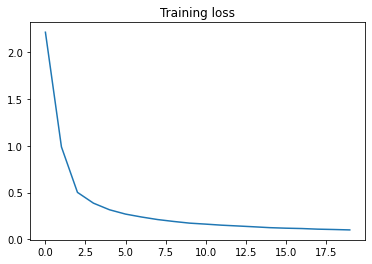

In [16]:
## YOUR CODE HERE ##
print(train_loss)
plt.plot(train_loss, label='Training loss');
plt.title('Training loss')

In [15]:
##MODEL TESTING##

#testing 
accuracy = 0
correct_preds =0 #number of correct predictions

with torch.no_grad(): #turn off gradients to stop keeping track of gradients 
    net.eval() #put the model in evaluation mode

    for images, labels in testloader:
        
        #move to the GPU
        images, labels = images.to(device), labels.to(device)
        
        #perform prediction 
        outputs = net(images)
        
        #compare the predcitions with the labels
        
        _, predictions = torch.max(outputs.data, 1)
        correct_preds += (predictions == labels).sum().item()
        
    accuracy = (correct_preds/len(test_data))*100

    print(f"Test accuracy: {accuracy:.3f}%")


Test accuracy: 97.470%


## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
## YOUR CODE HERE ##
torch.save(net, 'model.pt')